In [ ]:
!nvidia-smi

In [2]:
!pip install pytorchvideo
!pip install torchcam
!pip install --ignore-installed Pillow==9.0.0

     |████████████████████████████████| 132 kB 13.1 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 50 kB 6.7 MB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 30.7 MB 60.2 MB/s            
     |████████████████████████████████| 42 kB 829 kB/s             
  Preparing metadata (setup.py) ... done
  Created wheel for pytorchvideo: filename=pytorchvideo-0.1.5-py3-none-any.whl size=188715 sha256=5ad02d15cb3ee423b4b2ade3e4bd24cc54c66de39bb1dcd9d4b1b6660b485907
  Stored in directory: /root/.cache/pip/wheels/e8/51/05/053b29bac2400cbbae2fb7cfc41afd280d627bca7c9363ca80
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61433 sha256=d4d3d5dbaebf8eb37e0aed29888d888e1a782086ee99169ce5071e811c0999ce
  Stored in directory: /root/.cache/pip/wheels/af/cd/23/3fb62ec8606cb08cc18abb8d67bec255baf353623be889da1e
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-an

# --↓↓↓-- To Generate Class Activation Maps --↓↓↓--

- launch training first then stop it

In [6]:
import argparse
import math
import os
import random

import numpy as np
import pandas as pd
import torch
from pytorchvideo.data import make_clip_sampler, labeled_video_dataset
from pytorchvideo.models import create_slowfast
from torch.backends import cudnn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader
from tqdm import tqdm

#from utils import train_transform, test_transform, clip_duration, num_classes

from pytorchvideo.transforms import ApplyTransformToKey, UniformTemporalSubsample, RandomShortSideScale, \
    ShortSideScale, Normalize
from torch import nn
from torchvision.transforms import Compose, Lambda, RandomCrop, RandomHorizontalFlip, CenterCrop, ToPILImage

##########################

learning_rate = 0.02

weight_decay = 0.0001

batch_size = 1

# data_root = "/kaggle/input/ob40-tte20/OB40-TTE20/"
data_root = "/kaggle/input/cam-data/cam/"


epochs = 1
save_root = '/kaggle/working/CheckPoints/Batch_2_sgd_lr001'
##########################

side_size = 336
max_size = 336
#mean = [0.45, 0.45, 0.45]
#std = [0.225, 0.225, 0.225]

mean = [0, 0, 0]
std = [1, 1, 1]

crop_size = 336
num_frames = 32
sampling_rate = 1
frames_per_second = 32/6
clip_duration = (num_frames * sampling_rate) / frames_per_second
num_classes = 3

# for reproducibility
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
cudnn.deterministic = True
#cudnn.benchmark = True




class PackPathway(nn.Module):
    """
    Transform for converting video frames as a list of tensors.
    """

    def forward(self, frames):
        frame_list = frames
        # perform temporal sampling from the fast pathway.
        
        return frame_list


train_transform = ApplyTransformToKey(key="video", transform=Compose(
    [UniformTemporalSubsample(num_frames), Lambda(lambda x: x / 255.0), ShortSideScale(size=side_size),Normalize(mean, std), PackPathway()]))

test_transform = ApplyTransformToKey(key="video", transform=Compose(
    [UniformTemporalSubsample(num_frames), Lambda(lambda x: x / 255.0), ShortSideScale(size=side_size), Normalize(mean, std), PackPathway()]))

# test_transform = ApplyTransformToKey(key="video", transform=Compose(
#     [UniformTemporalSubsample(num_frames), ShortSideScale(size=side_size), PackPathway()]))





# train for one epoch
def train(model, data_loader, train_optimizer):
    model.train()
    total_loss, total_acc, total_num = 0.0, 0, 0
    train_bar = tqdm(data_loader, total=math.ceil(train_data.num_videos / batch_size), dynamic_ncols=True)
    for batch in train_bar:
        video, label =  batch['video'].cuda(), batch['label'].cuda()
        
        
        #print(video)
        
        
        train_optimizer.zero_grad()
        pred = model(video)
        loss = loss_criterion(pred, label)
        total_loss += loss.item() * video.size(0)
        total_acc += (torch.eq(pred.argmax(dim=-1), label)).sum().item()
        loss.backward()
        train_optimizer.step()

        total_num += video.size(0)
        train_bar.set_description('Train Epoch: [{}/{}] Loss: {:.4f} Acc: {:.2f}%'
                                  .format(epoch, epochs, total_loss / total_num, total_acc * 100 / total_num))
                

    return total_loss / total_num, total_acc / total_num


# test for one epoch
def val(model, data_loader):
    model.eval()
    with torch.no_grad():
        total_top_1, total_top_5, total_num = 0, 0, 0
        test_bar = tqdm(data_loader, total=math.ceil(test_data.num_videos / batch_size), dynamic_ncols=True)
        for batch in test_bar:
            #video, label = [i.cuda() for i in batch['video']], batch['label'].cuda()

            video, label =  batch['video'].cuda(), batch['label'].cuda()


            
            pred = model(video)
            
            #print(pred.argmax(dim=-1).cpu())
            pred_result.extend(pred.argmax(dim=-1).cpu())
            ground_truth.extend(label.cpu())
            #print(label)

            
            total_top_1 += (torch.eq(pred.argmax(dim=-1), label)).sum().item()
            total_top_5 += torch.any(torch.eq(pred.topk(k=2, dim=-1).indices, label.unsqueeze(dim=-1)),
                                     dim=-1).sum().item()
            total_num += video.size(0)
            test_bar.set_description('Test Epoch: [{}/{}] | Top-1:{:.2f}% | Top-5:{:.2f}%'
                                     .format(epoch, epochs, total_top_1 * 100 / total_num,
                                             total_top_5 * 100 / total_num))
    return total_top_1 / total_num, total_top_5 / total_num


# data prepare
train_data = labeled_video_dataset('{}/train'.format(data_root), make_clip_sampler('random', clip_duration),
                                   transform=train_transform, decode_audio=False)
test_data = labeled_video_dataset('{}/test'.format(data_root),
                                  make_clip_sampler('constant_clips_per_video', clip_duration, 1),
                                  transform=test_transform, decode_audio=False)
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=8)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=8)


#------------------------------------------------------------------------------------------------------------

# model define, loss setup and optimizer config
#slow_fast = create_slowfast(model_num_class=num_classes).cuda()
model_name = 'x3d_s'
model = torch.hub.load('facebookresearch/pytorchvideo:main', model_name, pretrained=True).cuda()


model.blocks[5].proj = torch.nn.Linear(in_features=2048, out_features=3, bias=True).cuda()

model.blocks[5].pool.pool = torch.nn.AvgPool3d(kernel_size=(1, 5, 5), stride=1, padding=0)

model.load_state_dict(torch.load('/kaggle/input/x3d-s-k1/x3d_s_k1.pth', 'cuda'))


#model.load_state_dict(torch.load('/kaggle/input/pretrained-weight/Batch_10_02.pth', 'cuda'))

#------------------------------------------------------------------------------------------------------------


loss_criterion = CrossEntropyLoss()
# optimizer = Adam(slow_fast.parameters(), lr=1e-1)
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)

# training loop
results = {'loss': [], 'acc': [], 'top-1': [], 'top-5': []}

pred_result = []
ground_truth = []

if not os.path.exists(save_root):
    os.makedirs(save_root)
best_acc = 0.0
for epoch in range(1, epochs + 1):
#     train_loss, train_acc = train(model, train_loader, optimizer)
#     results['loss'].append(train_loss)
#     results['acc'].append(train_acc * 100)
    top_1, top_5 = val(model, test_loader)
    results['top-1'].append(top_1 * 100)
    results['top-5'].append(top_5 * 100)
    
    #pred_result.extend(pred)
    #ground_truth.extend(label)
    
    
    # save statistics
    data_frame = pd.DataFrame(data=results, index=range(1, epoch + 1))
    data_frame.to_csv('{}/metrics.csv'.format(save_root), index_label='epoch')

    if top_1 > best_acc:
        best_acc = top_1
        torch.save(model.state_dict(), '{}/x3d.pth'.format(save_root))



/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Downloading: "https://github.com/facebookresearch/pytorchvideo/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/X3D_S.pyth" to /root/.cache/torch/hub/checkpoints/X3D_S.pyth


  0%|          | 0.00/29.4M [00:00<?, ?B/s]

  0%|          | 0/52 [00:09<?, ?it/s]


KeyboardInterrupt: 

# To Generate Class Activation Maps ---↑↑↑↑↑↑↑↑↑---

- launch training first then stop it

# --↓↓↓↓↓↓-- Run the Following Cells --↓↓↓↓↓↓--


In [7]:
model.eval()

Net(
  (blocks): ModuleList(
    (0): ResNetBasicStem(
      (conv): Conv2plus1d(
        (conv_t): Conv3d(3, 24, kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), bias=False)
        (conv_xy): Conv3d(24, 24, kernel_size=(5, 1, 1), stride=(1, 1, 1), padding=(2, 0, 0), groups=24, bias=False)
      )
      (norm): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (1): ResStage(
      (res_blocks): ModuleList(
        (0): ResBlock(
          (branch1_conv): Conv3d(24, 24, kernel_size=(1, 1, 1), stride=(1, 2, 2), bias=False)
          (branch2): BottleneckBlock(
            (conv_a): Conv3d(24, 54, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
            (norm_a): BatchNorm3d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act_a): ReLU()
            (conv_b): Conv3d(54, 54, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1), groups=54, bias=False)
            (nor

In [8]:
# Get a video frome dataloader
a = 35
random.seed(a)
np.random.seed(a)
torch.manual_seed(a)
# data_root = "/kaggle/input/cam-data/cam/"

test_loader = DataLoader(test_data, batch_size=1, num_workers=8)
test_features = next(iter(test_loader))
video = test_features['video']
label = test_features['label']

video.shape, label

(torch.Size([1, 3, 32, 336, 336]), tensor([2]))

In [9]:
video3 = video[0].permute((1,2,3,0))
video3 = video3.cpu().numpy()*255
video3 = np.uint8(video3)
video3.shape

(32, 336, 336, 3)

In [ ]:
# Visualise the input data
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 280))
for i in range(32):
    plt.subplot(32, 4, i+1) # (8, 8) 
    plt.imshow(video3[i])
    plt.axis('off')
    plt.tight_layout()
plt.show()

In [11]:
video = video.cuda()
pred = model(video)
pred.argmax(dim=-1).cpu(),pred

(tensor([2]),
 tensor([[1.4764e-05, 3.5942e-05, 9.9995e-01]], device='cuda:0',
        grad_fn=<ViewBackward>))

In [12]:
model_children=list(model.children())
fc1 = model_children[0][5].proj


In [13]:
cov0 = model_children[0][0](video)
cov1 = model_children[0][1](cov0)
cov2 = model_children[0][2](cov1)
cov3 = model_children[0][3](cov2)
cov4 = model_children[0][4](cov3)
conv5 = model_children[0][5].pool.pre_conv(cov4)
conv5 = model_children[0][5].pool.pre_norm(conv5)
conv5 = model_children[0][5].pool.pre_act(conv5)
average_pooling = model_children[0][5].pool.pool(conv5)
post_conv = model_children[0][5].pool.post_conv(average_pooling)
patch_feature = model_children[0][5].pool.post_act(post_conv)

In [14]:
patch_feature.shape

torch.Size([1, 2048, 32, 7, 7])

In [15]:
import torch
from torch import nn
import torch.nn.functional as F
from typing import Any, List, Optional, Tuple, Union
from torch import Tensor, nn
import numpy as np

# fc1 = model_children[0][5].proj
feature = patch_feature[0].permute((-3,-2,-1,-4))
fc_layer, class_idx = fc1,2

fc_weights = fc_layer.weight.data
if fc_weights.ndim > 2:
    print('1')
    weights = fc_weights.view(*fc_weights.shape[:2])
if isinstance(class_idx, int):
    print('2')
    weights= fc_weights[class_idx, :].unsqueeze(0)
else:
    print('3')
    weights = fc_weights[class_idx, :]

patch_feats = feature

def normalize(cams: Tensor, spatial_dims: Optional[int] = None) -> Tensor:
    """CAM normalization."""
    cams.sub_(cams.min(-1).values[(..., None)])
    cams_max = cams.max(-1).values[(..., None)]
    cams_max = torch.clamp(cams_max, min = 1e-12, max = 1)
    cams.div_(cams_max)
    return cams

with torch.no_grad():
# n_cam = weights.shape[0]
#patch_feats = patch_feats.unsqueeze(1).expand(patch_feats.shape[0], n_cam, patch_feats.shape[1],patch_feats.shape[2])
    cams = torch.matmul(patch_feats, weights.transpose(-2,-1)).transpose(-2,-1)
# print(cams.shape)
#
#
#     for weight, activation in zip(weights, patch_feats):
#         # missing_dims = activation.ndim - weight.ndim  # type: ignore[union-attr]
#         # weight = weight[(...,) + (None,) * missing_dims]
#
#         # Perform the weighted combination to get the CAM
#         cam = torch.nansum(weight * activation, dim=1)  # type: ignore[union-attr]

normalized = True
relu = False
if relu:
    cams = F.relu(cams, inplace=True)
# Normalize the CAM
# cams = normalize(cams)

2


In [16]:
activation_map = cams
# activation_map = cams.reshape(32*7*7)
activation_map -= activation_map.min()
activation_map /= activation_map.max()
# activation_map = activation_map.reshape(32,7,1,7)
activation_map = activation_map.permute((0,1,3,2))

# activation_map = torch.flatten(activation_map)

# activation_map = normalize(activation_map, p=1.0, dim = 0)
# activation_map = activation_map.reshape(32,7,7,1)
activation_map = activation_map.cpu().numpy()
activation_map.shape

(32, 7, 7, 1)

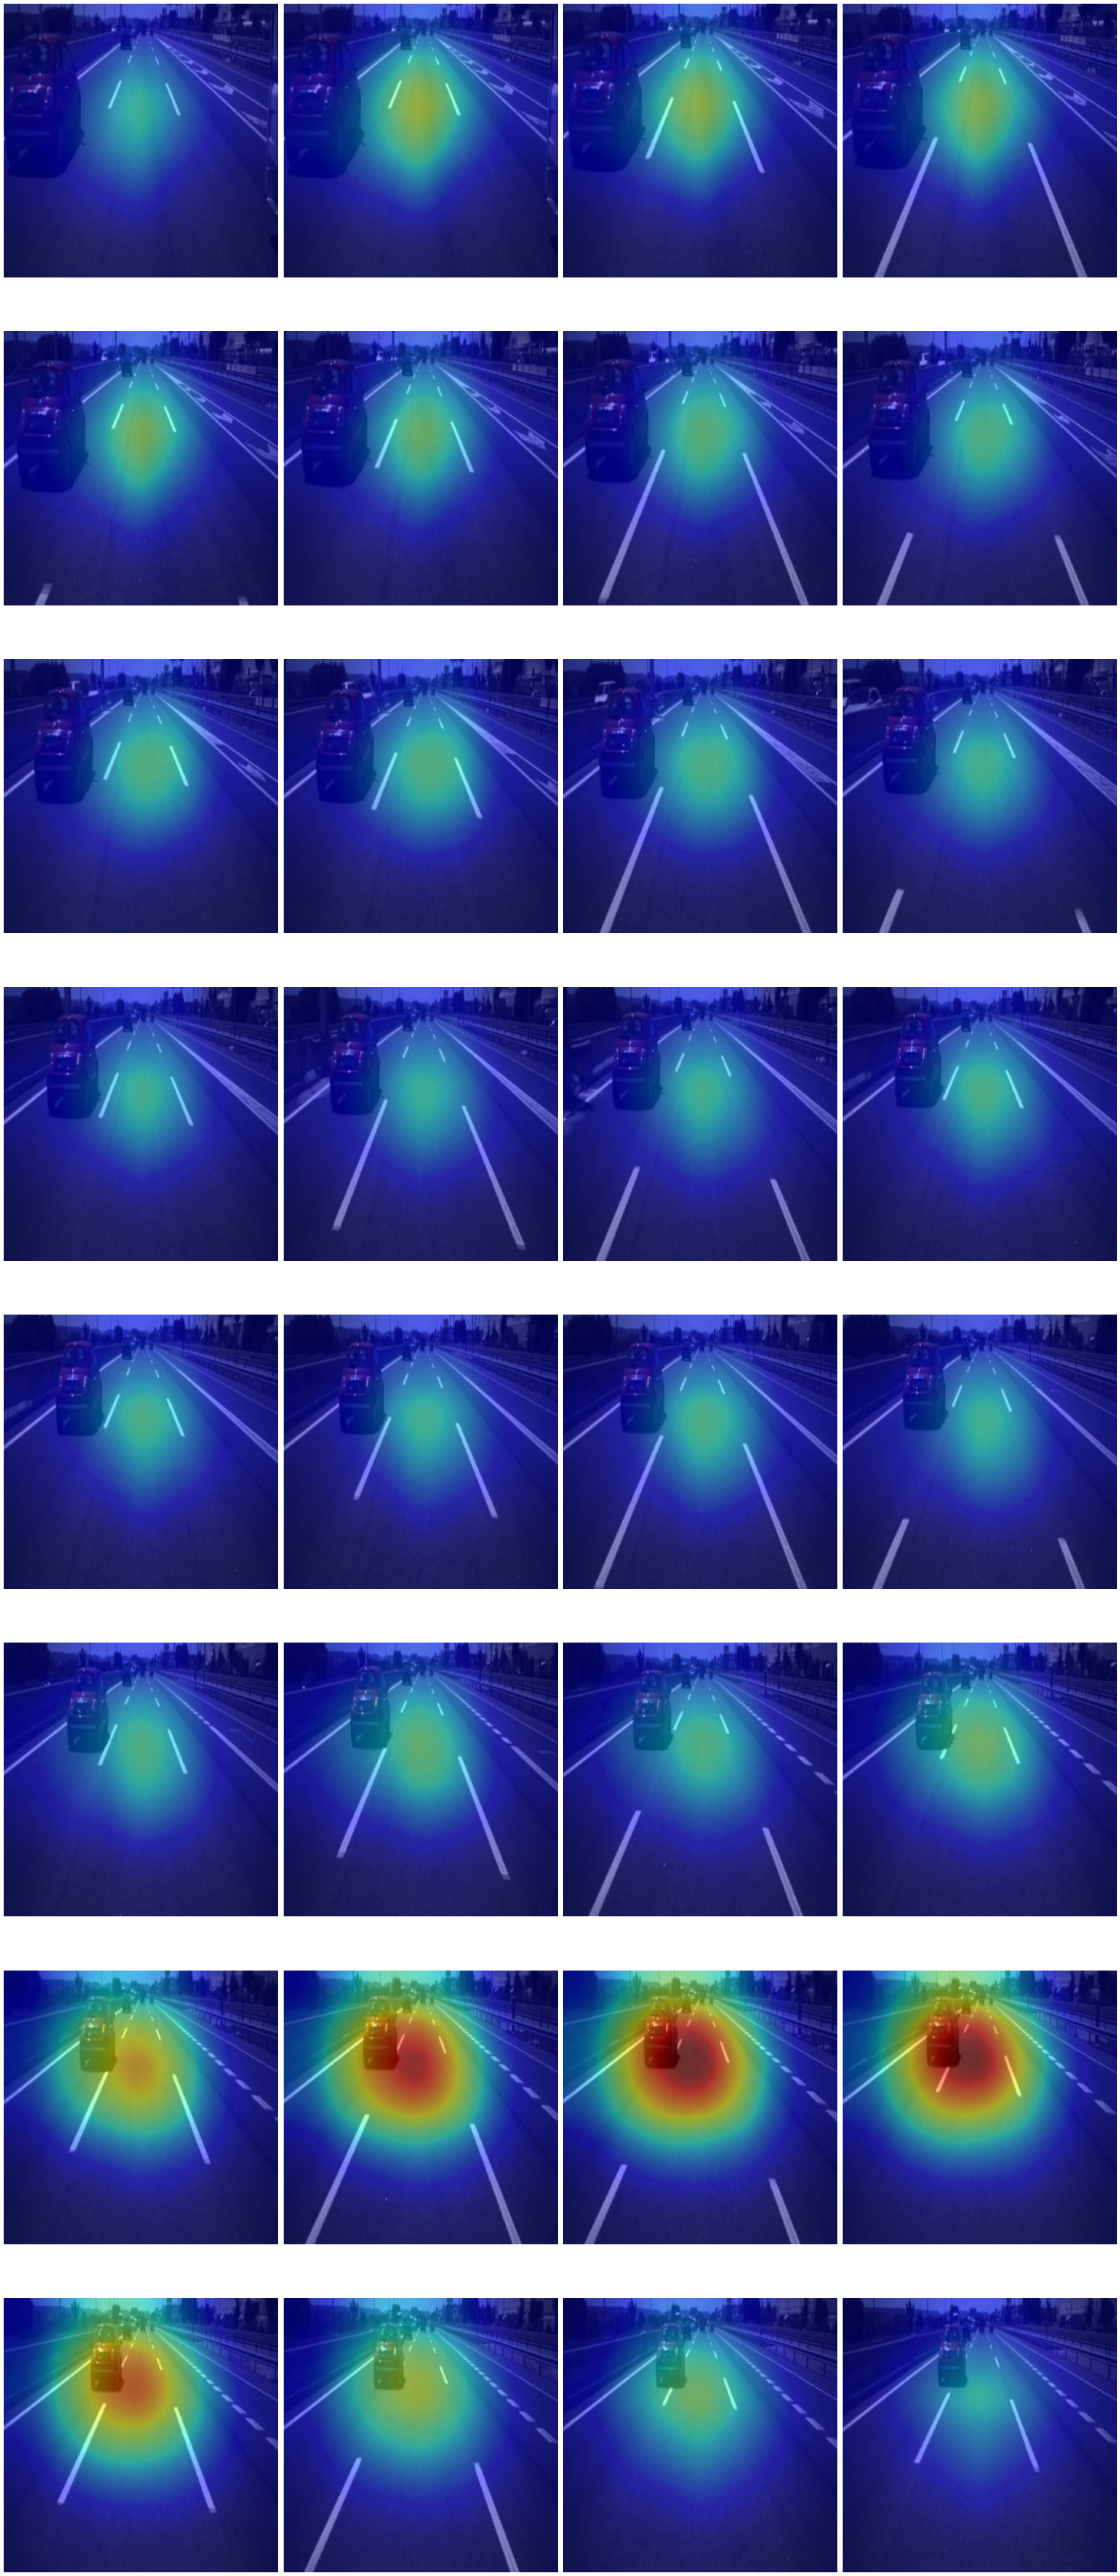

In [17]:
# Visualise CAM
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import normalize, resize, to_pil_image


import matplotlib.pyplot as plt

plt.figure(figsize=(30, 280))
for i in range(32):
    result = overlay_mask(to_pil_image(video3[i]), to_pil_image(activation_map[i], mode='F'), alpha=0.5)

    plt.subplot(32, 4, i+1) # (8, 8) 
    plt.imshow(result)
    plt.axis('off')
    plt.tight_layout()
plt.show()

# -------↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑-------